In [32]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

class BTPCertificatePricer:
    
    def __init__(self, 
                 # BTP parameters
                 spot_rate=3.5, 
                 volatility=0.10, 
                 maturity_years=7,
                 coupon_rate=0.0118, 
                 coupon_barrier=4.0, 
                 autocall_barrier=3.0,
                 mean_reversion_speed=0.1, 
                 long_term_mean=None,
                 # Euribor parameters
                 euribor_spot=3.0,  
                 euribor_volatility=0.08,  
                 euribor_spread=0.16,  
                 correlation=0.85,  
                 mean_reversion_speed_euribor=0.12):
        # BTP parameters
        self.spot_rate = spot_rate
        self.volatility = volatility
        self.maturity_years = maturity_years
        self.coupon_rate = coupon_rate
        self.coupon_barrier = coupon_barrier
        self.autocall_barrier = autocall_barrier
        self.kappa = mean_reversion_speed
        self.theta = long_term_mean if long_term_mean is not None else spot_rate
        
        # Euribor parameters
        self.euribor_spot = euribor_spot
        self.euribor_volatility = euribor_volatility
        self.euribor_spread = euribor_spread
        self.correlation = correlation
        self.kappa_euribor = mean_reversion_speed_euribor
        self.theta_euribor = euribor_spot  # Assumiamo mean reversion verso spot
        
        # Calcolo trimestrale
        self.quarters_per_year = 4
        self.total_quarters = maturity_years * self.quarters_per_year
        self.dt = 1.0 / self.quarters_per_year  # 0.25 anni
        
        self.semesters_per_year = 2
        self.total_semesters = maturity_years * self.semesters_per_year
        
    def simulate_rate_paths(self, n_simulations=10000, random_seed=None):
        """
        Simula path di BTP ed Euribor usando processi Vasicek correlati.
        
        BTP: dr_BTP(t) = κ_BTP(θ_BTP - r_BTP(t))dt + σ_BTP dW_BTP(t)
        Euribor: dr_EUR(t) = κ_EUR(θ_EUR - r_EUR(t))dt + σ_EUR dW_EUR(t)
        
        Con correlazione: E[dW_BTP * dW_EUR] = ρ dt
        
        Returns:
        --------
        tuple: (btp_paths, euribor_paths)
            btp_paths: shape (n_simulations, total_quarters + 1)
            euribor_paths: shape (n_simulations, total_quarters + 1)
        """
        if random_seed is not None:
            np.random.seed(random_seed)
        
        # Inizializza array
        btp_paths = np.zeros((n_simulations, self.total_quarters + 1))
        euribor_paths = np.zeros((n_simulations, self.total_quarters + 1))
        
        btp_paths[:, 0] = self.spot_rate
        euribor_paths[:, 0] = self.euribor_spot
        
        # Simula ogni trimestre
        for t in range(self.total_quarters):
            Z1 = np.random.normal(0, 1, n_simulations)
            Z2 = np.random.normal(0, 1, n_simulations)
            
            dW_BTP = Z1
            dW_EUR = self.correlation * Z1 + np.sqrt(1 - self.correlation**2) * Z2
            
            # BTP Vasicek
            drift_BTP = self.kappa * (self.theta - btp_paths[:, t]) * self.dt
            diffusion_BTP = self.volatility * np.sqrt(self.dt) * dW_BTP
            btp_paths[:, t + 1] = btp_paths[:, t] + drift_BTP + diffusion_BTP
            
            # Euribor Vasicek
            drift_EUR = self.kappa_euribor * (self.theta_euribor - euribor_paths[:, t]) * self.dt
            diffusion_EUR = self.euribor_volatility * np.sqrt(self.dt) * dW_EUR
            euribor_paths[:, t + 1] = euribor_paths[:, t] + drift_EUR + diffusion_EUR
        
        return btp_paths, euribor_paths
    
    
    def evaluate_btp_option(self, btp_paths):
        n_simulations = btp_paths.shape[0]

        autocall_count = 0
        autocall_times = []
        payoffs = np.zeros_like(btp_paths)
        payment_times = np.zeros_like(btp_paths) 

        for i in range(n_simulations):
            rate_path = btp_paths[i, :]
            memorized_coupon = 0.0     

            for j in range(len(rate_path)):
                if j == 0:
                    continue
                current_rate = rate_path[j]
                t = j * self.dt  

                # 1. Verifica condizione coupon: se tasso < 4%, paga coupon corrente + memoria
                if current_rate <= self.coupon_barrier:
                    payoffs[i, j] = self.coupon_rate + memorized_coupon
                    payment_times[i, j] = t  
                    memorized_coupon = 0
                else:
                    memorized_coupon += self.coupon_rate 

                # 2. Verifica condizione autocall: se tasso < 3% in questo trimestre, richiama
                if current_rate <= self.autocall_barrier:
                    autocall_count += 1
                    autocall_times.append(t)
                    break  

        stats = {
                    'autocall_count': autocall_count,
                    'autocall_probability': autocall_count / n_simulations,
                    'autocall_times': np.array(autocall_times).mean() if autocall_times else 0,
                    'avg_payoff': np.mean(payoffs),
                    'payment_times': payment_times  
                }
        return payoffs, stats
    
    
    def evaluate_funding_swap(self, btp_paths, euribor_paths):
        """
        Valuta il payoff della gamba di funding.
        
        Swap paga: Euribor 6M + 16 bps
        """
        n_simulations = btp_paths.shape[0]

        autocall_count = 0
        autocall_times = []
        payoffs = np.zeros_like(btp_paths)
        payment_times = np.zeros_like(btp_paths)  

        for i in range(n_simulations):
            rate_path = btp_paths[i, :]
            euribor_path = euribor_paths[i, :]

            for j in range(len(rate_path)):
                if j == 0:
                    continue
                current_rate = rate_path[j]
                t = j * self.dt  

                # 2. Verifica condizione autocall: se tasso < 3% in questo trimestre, richiama
                if current_rate <= self.autocall_barrier:
                    autocall_count += 1
                    autocall_times.append(t)
                    break  

                payoffs[i, j] = (euribor_path[j] + self.euribor_spread)/4
                payment_times[i, j] = t  

        stats = {
                    'autocall_count': autocall_count,
                    'autocall_probability': autocall_count / n_simulations,
                    'autocall_times': np.array(autocall_times).mean() if autocall_times else 0,
                    'avg_payoff': np.mean(payoffs),
                    'payment_times': payment_times  
                }
        return payoffs, stats
    
    


In [ ]:

pricer = BTPCertificatePricer(
    # BTP parameters
    spot_rate=3.65,           # Tasso spot iniziale 3.5%
    volatility=0.6,          # Volatilità 60 bps
    maturity_years=7,        # Maturity 7 anni
    coupon_rate=1.125,      # Cedola 1.125% trim
    coupon_barrier=3.5,      # Soglia cedola 4%
    autocall_barrier=2.5,    # Soglia autocall 3%
    mean_reversion_speed=0.1, # speed mean reversion
    
    # Euribor parameters
    euribor_spot=2.67,        # Euribor 6M spot iniziale (ho messo il fair rate)
    euribor_volatility=0.55, # Volatilità Euribor
    euribor_spread=0.46,   # Margine 16 bps = 0.16
    correlation=0.85,        # Correlazione tra BTP ed Euribor
    mean_reversion_speed_euribor=0.12
)


In [34]:
n_simulations=10000
random_seed=42
btp_paths, euribor_paths = pricer.simulate_rate_paths(n_simulations, random_seed)
# Valuta BTP Certificate
btp_payoffs, btp_stats = pricer.evaluate_btp_option(btp_paths)
btp_exp_payoffs = btp_payoffs.mean(axis=0)
swap_payoffs, swap_stats = pricer.evaluate_funding_swap(btp_paths, euribor_paths)
swap_exp_payoffs = swap_payoffs.mean(axis=0)

# Discounting con tasso 1.92%
discount_rate = 0.023
discounting = lambda t: np.exp(-discount_rate * t)

# Applica discounting ai payoffs BTP
btp_payment_times = btp_stats['payment_times']
swap_payment_times = swap_stats['payment_times']


btp_discounted_payoffs = btp_exp_payoffs * discounting(btp_payment_times).mean(axis=0)
swap_discounted_payoffs = swap_exp_payoffs * discounting(swap_payment_times).mean(axis=0)

print(f"BTP Leg: {btp_discounted_payoffs.sum():.2f}")
print(f"Funding Leg: {swap_discounted_payoffs.sum():.2f}")
print("*")
print(f"Upfront: {(swap_discounted_payoffs.sum() - btp_discounted_payoffs.sum()):.2f}")


BTP Leg: 14.65
Funding Leg: 16.51
*
Upfront: 1.86


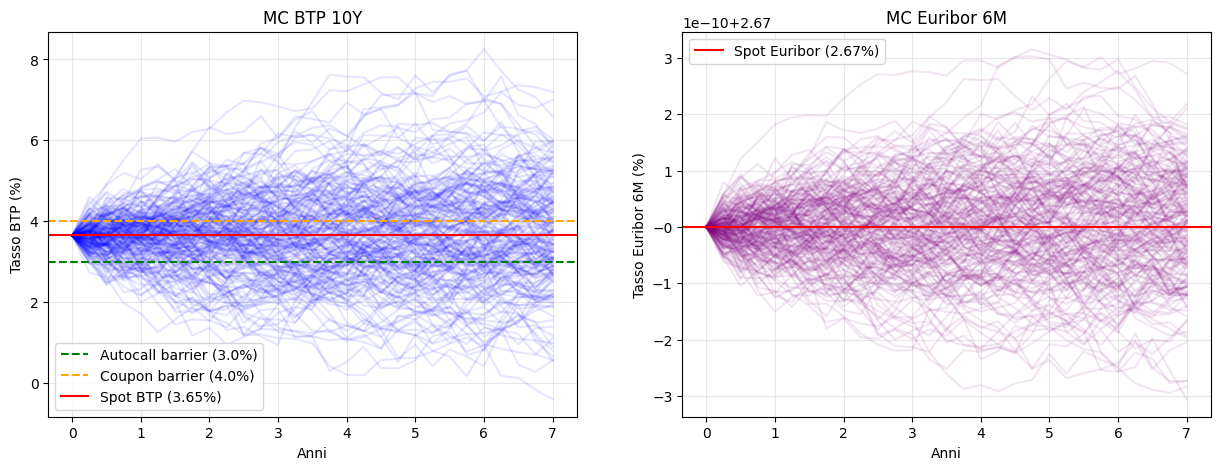

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

n_paths_to_plot = 200

quarters = np.arange(pricer.total_quarters + 1) * pricer.dt

# Plot 1: Path BTP
ax1 = axes[ 0]
for i in range(min(n_paths_to_plot, btp_paths.shape[0])):
    ax1.plot(quarters, btp_paths[i, :], alpha=0.1, color='blue')
ax1.axhline(y=pricer.autocall_barrier, color='green', linestyle='--', 
            label=f'Autocall barrier ({pricer.autocall_barrier}%)')
ax1.axhline(y=pricer.coupon_barrier, color='orange', linestyle='--', 
            label=f'Coupon barrier ({pricer.coupon_barrier}%)')
ax1.axhline(y=pricer.spot_rate, color='red', linestyle='-', 
            label=f'Spot BTP ({pricer.spot_rate}%)')
ax1.set_xlabel('Anni')
ax1.set_ylabel('Tasso BTP (%)')
ax1.set_title('MC BTP 10Y')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Path Euribor
ax2 = axes[1]
for i in range(min(n_paths_to_plot, euribor_paths.shape[0])):
    ax2.plot(quarters, euribor_paths[i, :], alpha=0.1, color='purple')
ax2.axhline(y=pricer.euribor_spot, color='red', linestyle='-', 
            label=f'Spot Euribor ({pricer.euribor_spot}%)')
ax2.set_xlabel('Anni')
ax2.set_ylabel('Tasso Euribor 6M (%)')
ax2.set_title('MC Euribor 6M')
ax2.legend()
ax2.grid(True, alpha=0.3)